In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [5]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))
    return X_reshaped, y

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[1 0 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/10
6449/6449 [==============================] - 393s 60ms/step - loss: 0.2188 - accuracy: 0.8848
Epoch 2/10
6449/6449 [==============================] - 365s 57ms/step - loss: 0.1764 - accuracy: 0.9064
Epoch 3/10
6449/6449 [==============================] - 366s 57ms/step - loss: 0.1640 - accuracy: 0.9141
Epoch 4/10
6449/6449 [==============================] - 382s 59ms/step - loss: 0.1549 - accuracy: 0.9185
Epoch 5/10
6449/6449 [==============================] - 393s 61ms/step - loss: 0.1496 - accuracy: 0.9205
Epoch 6/10
6449/6449 [==============================] - 403s 62ms/step - loss: 0.1466 - accuracy: 0.9219
Epoch 7/10
6449/6449 [==============================] - 383s 59ms/step - loss: 0.1443 - accuracy: 0.9224
Epoch 8/10
6449/6449 [==============================] - 399s 62ms/step - loss: 0.1422 - accuracy: 0.9233
Epoch 9/10
6449/6449 [==============================] - 404s 63ms/step - loss: 0.1407 - accuracy: 0.9237
Epoch 10/10
6449/6449 [==============================] 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


731/731 [==============================] - 46s 55ms/step - loss: 0.3707 - accuracy: 0.8483
Epoch 2/10
731/731 [==============================] - 45s 62ms/step - loss: 0.2381 - accuracy: 0.9074
Epoch 3/10
731/731 [==============================] - 50s 69ms/step - loss: 0.2210 - accuracy: 0.9121
Epoch 4/10
731/731 [==============================] - 46s 63ms/step - loss: 0.2097 - accuracy: 0.9148
Epoch 5/10
731/731 [==============================] - 46s 62ms/step - loss: 0.2040 - accuracy: 0.9190
Epoch 6/10
731/731 [==============================] - 45s 62ms/step - loss: 0.1977 - accuracy: 0.9201
Epoch 7/10
731/731 [==============================] - 44s 61ms/step - loss: 0.1933 - accuracy: 0.9231
Epoch 8/10
731/731 [==============================] - 45s 62ms/step - loss: 0.1913 - accuracy: 0.9239
Epoch 9/10
731/731 [==============================] - 47s 65ms/step - loss: 0.1898 - accuracy: 0.9251
Epoch 10/10
731/731 [==============================] - 46s 63ms/step - loss: 0.1860 - accurac

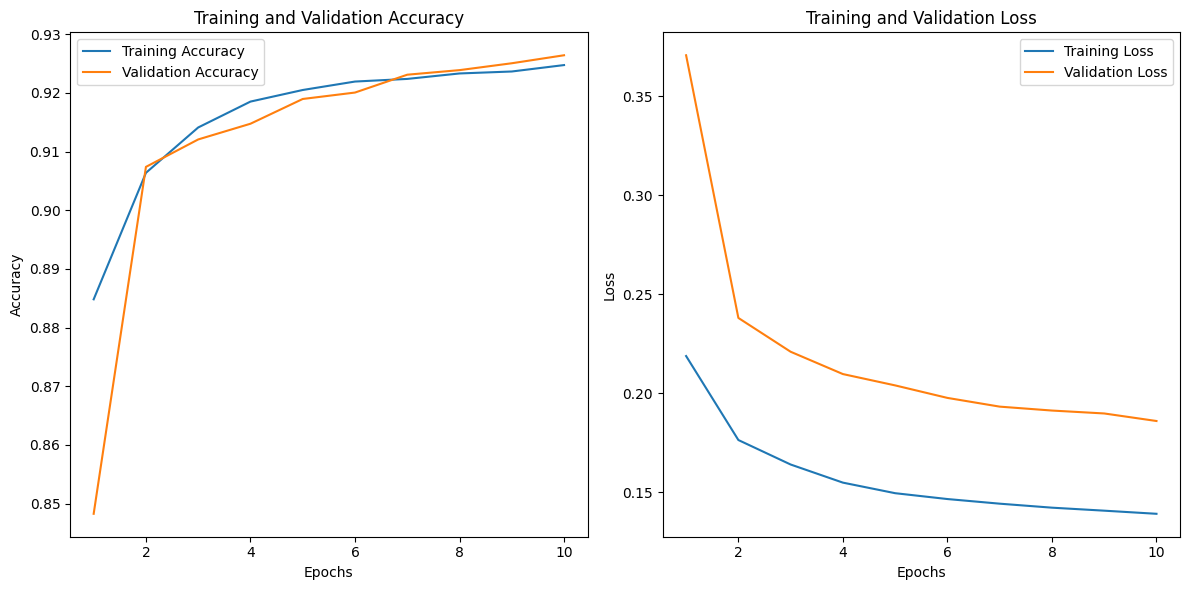

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


386/386 [==============================] - 5s 8ms/step - loss: 1.3838 - accuracy: 0.5444
Final accuracy on the test dataset: 0.5444444417953491
Final loss on the test dataset: 1.3838125467300415
386/386 [==============================] - 5s 9ms/step
F1 Score: 0.19270697064555412


(None, None)

In [6]:
def process_folder(folder_path, is_test=False):
    X_batches = []
    y_batches = []

    # Recursively iterate through subfolders
    for root, dirs, files in os.walk(folder_path):
        for subfolder in dirs:
            subfolder_path = os.path.join(root, subfolder)
            file_paths = [os.path.join(subfolder_path, filename) for filename in os.listdir(subfolder_path) if filename.endswith(".csv")]
            if file_paths:
                for file_path in file_paths:
                    if os.path.basename(file_path) == "dates.csv":
                        print("Skipping file:", file_path)
                        continue

                    X, y = load_and_preprocess_data(file_path)
                    X_batches.append(X)
                    y_batches.append(y)

    if X_batches:
        X_data = np.concatenate(X_batches)
        y_data = np.concatenate(y_batches)

        # Define the LSTM model
        inputs = Input(shape=(X_data.shape[1], X_data.shape[2]))
        lstm_layer1 = LSTM(units=64, return_sequences=True)(inputs)
        dropout1 = Dropout(0.5)(lstm_layer1)
        lstm_layer2 = LSTM(units=64, return_sequences=True)(dropout1)
        dropout2 = Dropout(0.5)(lstm_layer2)
        lstm_layer3 = LSTM(units=64)(dropout2)
        dropout3 = Dropout(0.5)(lstm_layer3)
        outputs = Dense(4, activation='softmax')(dropout3)
        model = Model(inputs=inputs, outputs=outputs)

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # One-hot encode the target data
        y_data_encoded = to_categorical(y_data)

        # Compute class weights
        class_weights = compute_class_weight('balanced', np.unique(y_data), y_data)
        class_weight = {i: class_weights[i] for i in range(len(class_weights))}

        # Train the model
        if not is_test:
            # Train the model on the entire dataset without validation split
            history = model.fit(X_data, y_data_encoded, epochs=10, batch_size=200, verbose=1, class_weight=class_weight)
        else:
            # Evaluate the model on the test dataset
            test_loss, test_accuracy = model.evaluate(X_data, y_data_encoded)
            print("Final accuracy on the test dataset:", test_accuracy)
            print("Final loss on the test dataset:", test_loss)

            # Calculate F1 score
            y_pred = model.predict(X_data)
            y_pred_classes = np.argmax(y_pred, axis=1)
            f1 = f1_score(y_data, y_pred_classes, average='macro')  # or 'micro'
            print("F1 Score:", f1)

            # Return None for train_accuracy and train_loss in test mode
            return None, None

        tf.keras.backend.clear_session()
        del model

        # Return training accuracy, validation accuracy, training loss, and validation loss if available
        if not is_test:
            train_accuracy = history.history['accuracy']
            train_loss = history.history['loss']
            return train_accuracy, train_loss

# Define paths for the training, validation, and test datasets
train_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/CropWiseSimplified/14/train"
validate_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/CropWiseSimplified/14/valid"
test_folder_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/CropWiseSimplified/14/test"

# Process the training dataset
train_accuracy, train_loss = process_folder(train_folder_path)

# Process the validation dataset (no need for validation split)
val_accuracy, val_loss = process_folder(validate_folder_path)

# Plot training and validation accuracy in a single graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
if train_accuracy:
    plt.plot(range(1, 11), train_accuracy, label='Training Accuracy')  # Update the range to match the number of epochs
if val_accuracy:
    plt.plot(range(1, 11), val_accuracy, label='Validation Accuracy')  # Update the range to match the number of epochs
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
if train_loss:
    plt.plot(range(1, 11), train_loss, label='Training Loss')  # Update the range to match the number of epochs
if val_loss:
    plt.plot(range(1, 11), val_loss, label='Validation Loss')  # Update the range to match the number of epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Process the test dataset
process_folder(test_folder_path, is_test=True)
